# py_equality-constraints_revcx.ipynb
## modified from Lecture 4 of CMU16-745 (2024)

**Note** This version specifies constraint $c(x) \ge 0$
to conform to 2025 's formulation.

Solve inequality constraint case using augmented Lagrange method.
This example does not use forwarddiff, so JAX is not required.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from numpy.linalg import norm, solve
#import jax
#import jax.numpy as jnp

In [2]:
Q = np.diag([0.5,1])
Q
# objective function
def f(x):
    x1 = np.array(x) - np.array([[1],[0]])
    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = np.array(x) - np.array([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q


In [19]:
# constraint and gradient
A = np.array([-1.0, 1.0])
#print(A.shape)
b = 1.0
             
def c(x):
    return (np.dot(A,x) - b)

def dc(x):
    return A  


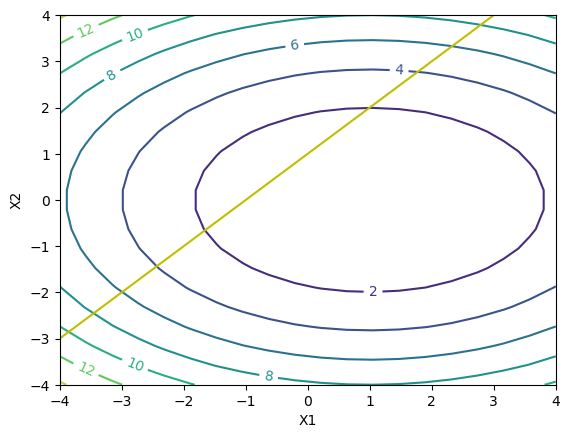

In [14]:
def plot_landscape():
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f([[X[j,k]], [Y[j,k]]])
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    xc = np.linspace(-4,3, Nsamp)
    yc = xc+1
    ax.plot(xc,yc,'y-')

    return ax

ax = plot_landscape()   

In [5]:
def La(x, Lambda, rho):
    p = np.minimum(0,c(x))
    return f(x) - Lambda*p + (rho/2)*p**2

In [24]:
def newton_solve(x0, Lambda, rho,debug=0):
    # set debug=1 to print out variables 
    i = 1 # iteration count for debug purpose
    x = np.expand_dims(x0,axis=1)
    cx = c(x)
    p = np.minimum(0, cx)
    if debug:
        print("Before while loop")
        print("p = ")
        print(p)
    C = np.zeros((1,2))
    if (cx <= 0):
        C = dc(x).reshape((1,2))
    g = df(x) + (-Lambda+rho*p)*C.T
    if debug:
        print("df(x) = ")
        print(df(x))
        print("(Lambda+rho*p)*C.T = ")
        print((Lambda+rho*p)*C.T)
        print("g = ")
        print(g)
    while norm(g) >= 1e-8:
        H = d2f(x) + rho*C.T@C  
        if debug:
            print("                    ")
            print("=====================")
            print("Iteration {}".format(i))
            print("d2f(x) = ")
            print(d2f(x))
            print("rho*C.T@C = ")
            print(rho*C.T@C)
            print("H = ")
            print(H)
        dx = solve(-H,g)
        x = x + dx        
        if debug:
            print("dx = ")
            print(dx)
            print("x = ")
            print(x)
        cx = c(x)
        if debug:        
            print("cx = ")
            print(cx)
        p = np.minimum(0, cx);
        if debug:
            print("p = ")
            print(p)
        
        C = np.zeros((1,2));
        if (cx <= 0):
            C = dc(x).reshape((1,2))
        if debug:
            print("C = ")
            print(C)
            print("C shape = ")
            print(C.shape)
        g = df(x) + (-Lambda+rho*p)*C.T; 
        if debug:
            print("df(x) = ")
            print(df(x))
            print("Lambda+rho*p)*C.T = ")
            print((Lambda+rho*p)*C.T)
            print("g = ")
            print(g)        
        i+=1
    return x
        

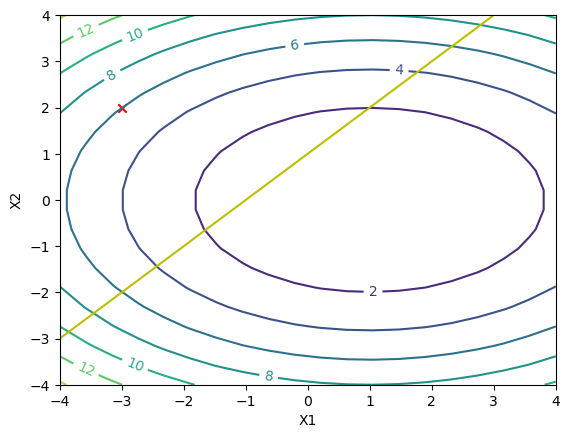

In [21]:
xguess = np.array([[-3.0],[2.0]])
lambdaguess = [0.0]
rho = 1.0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

In [8]:
# function to plot each optimization step.
# modified for better visualization.
def plot_steps(xguess):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        # print("x1_old = {}, x1_new = {}, x2_old = {}, x2_new = {}".format(x1_old,x1_new,x2_old,x2_new))
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m')    

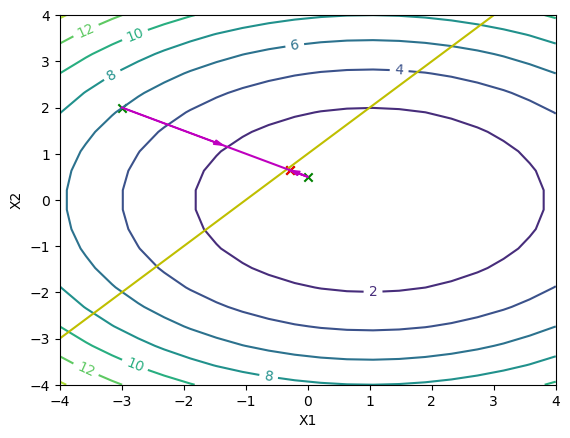

In [23]:
xnew = newton_solve(xguess[:,-1],lambdaguess[-1],rho);
lambdanew = np.maximum(0, lambdaguess[-1]+rho*c(xnew))
xguess = np.hstack((xguess, xnew))
lambdaguess.append(lambdanew)
rho = 10*rho
plot_steps(xguess)